# GPN-CUP

В предыдущем файле была проведена предобработка данных, построены таблицы для кластеризации и прогнозирования. В этом файле будут выполнены кластеризация и построение прогнозной модели по кластеризированным данным. 

## Кластеризация

### Кластеризация на основе факторов

Первый вариант заключается в проведении кластеризации по факторам, оказывающим влияние на продажи. Такая кластеризация позволяет сузить количество признаков в прогнозной модели: вместо всех имеющихся признаков использовать только один: кластер (используем фиктивные переменные). Для этой же цели также может быть использован метод главных компонент. 

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from tqdm import tqdm 

In [3]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score

In [4]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
plt.rcParams['figure.figsize'] = (10, 6)

In [6]:
encoded_shops = pd.read_csv('clustering/encoded_shops.csv', index_col=0)
encoded_shops.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37
shop_id,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


Будем проводить агломеративную кластеризацию данных. Сначала построим полное дерево и отобразим его дендрограмму. Поскольку все признаки закодированы в бинарные, в качестве метрики будем использовать количество несовпадающих позиций. Составим матрицу расстояний. 

In [7]:
X = encoded_shops.values
X.shape

(845, 38)

In [8]:
distance_matrix = np.abs(X - X[:, np.newaxis]).sum(axis=2)
distance_matrix.shape

(845, 845)

Переходим к кластерному анализу

In [9]:
cls = AgglomerativeClustering(n_clusters=None, 
                              affinity='precomputed',  
                              linkage='average', 
                              distance_threshold=0)
cls.fit(distance_matrix)

AgglomerativeClustering(affinity='precomputed', distance_threshold=0,
                        linkage='average', n_clusters=None)

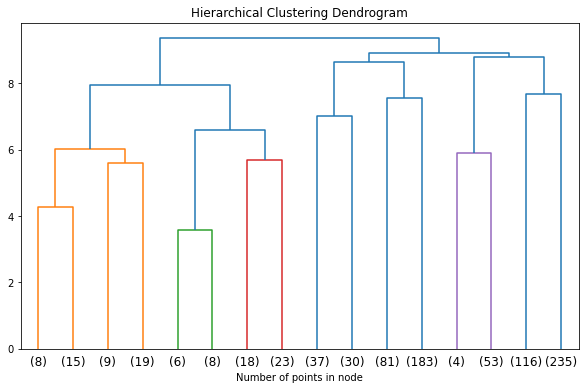

In [10]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(cls, truncate_mode='level', p=3)
plt.xlabel('Number of points in node')
plt.show()

Используем силуэт и индекс Дэвиса-Боулдина для оценки кластеризации и выбора наилучшего числа кластеров

In [11]:
davies_bouldin = []
silhouette = []

possible_n = np.arange(2, 400)

for n in possible_n:
    cls = AgglomerativeClustering(n_clusters=n, 
                                  affinity='precomputed',  
                                  linkage='average')
    labels = cls.fit_predict(distance_matrix)
    
    davies_bouldin.append(davies_bouldin_score(X, labels))
    silhouette.append(silhouette_score(X, labels))
    
davies_bouldin = np.array(davies_bouldin)
silhouette = np.array(silhouette)

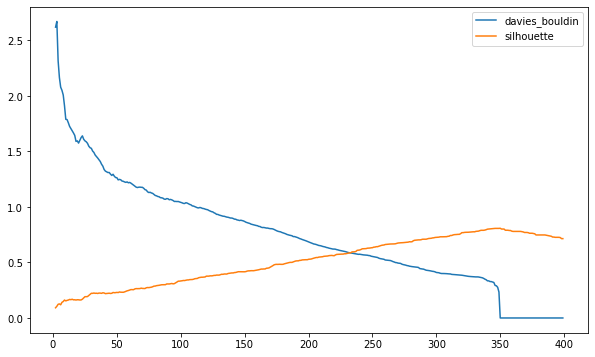

In [12]:
plt.plot(possible_n, davies_bouldin, label='davies_bouldin')
plt.plot(possible_n, silhouette, label='silhouette')
plt.legend()
plt.show()

Итак, согласно выбранным метрикам, наилучшее разбиение достигается при числе кластеров $n = 350$. При этом по критерию Дэвиса-Боулдина при $n = 350$ разбиение не просто наилучшее, а идеальное, т. к. значение критерия равно нулю. 

In [13]:
possible_n[davies_bouldin.argmin()]

350

In [14]:
possible_n[silhouette.argmax()]

350

In [15]:
cls = AgglomerativeClustering(n_clusters=350, 
                              affinity='precomputed',  
                              linkage='average')
labels350 = cls.fit_predict(distance_matrix)

Однако, это слишком большое количество кластеров и останавливаться на достигнутом не стоит. Используем метод главных компонент для сужения пространства признаков. 

In [16]:
from sklearn.decomposition import PCA

In [17]:
pca = PCA().fit(X)

In [18]:
Y = pca.transform(X)
Y.shape

(845, 38)

Посмотрим на долю объясняющей дисперсии

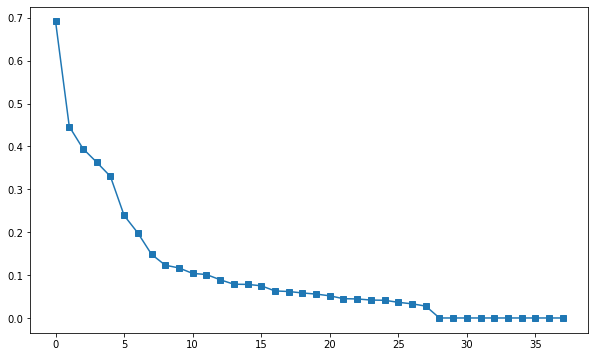

In [19]:
plt.plot(np.arange(38), pca.explained_variance_, marker='s')
plt.show()

По критерию каменистой осыпи выбираем число факторов (главных компонент) равным восьми. К результатам применяем кластерный анализ. Поскольку теперь факторы не бинарные, метрику надо изменить, например, на расстояние городских кварталов. 

In [20]:
X = Y[:, :8]

In [21]:
davies_bouldin = []
silhouette = []

possible_n = np.arange(2, 400)

for n in possible_n:
    cls = AgglomerativeClustering(n_clusters=n, 
                                  affinity='manhattan',  
                                  linkage='average')
    labels = cls.fit_predict(X)
    
    davies_bouldin.append(davies_bouldin_score(X, labels))
    silhouette.append(silhouette_score(X, labels))
    
davies_bouldin = np.array(davies_bouldin)
silhouette = np.array(silhouette)

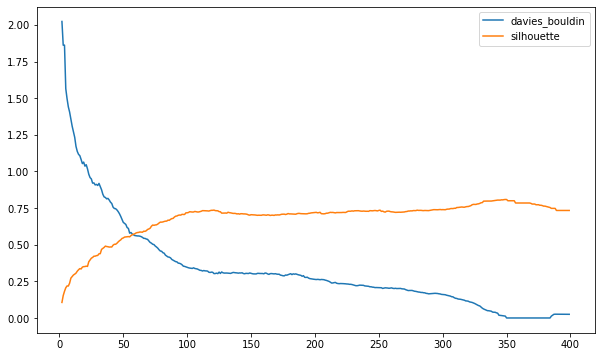

In [22]:
plt.plot(possible_n, davies_bouldin, label='davies_bouldin')
plt.plot(possible_n, silhouette, label='silhouette')
plt.legend()
plt.show()

Как можно видеть на картинке, лучшее разбиение всё ещё достигается при $n = 350$, что косвенно свидетельствует о том, что сужение пространства признаков методом главных компонент прошло успешно. Однако теперь качество кластеризации с увеличением числа кластеров растёт быстрее. При $n = 30$ и при $n = 55$ наблюдаются локальные минимумы индекса Дэвиса-Боулдина, можно взять соответсвующие этим точкам разбиения. 

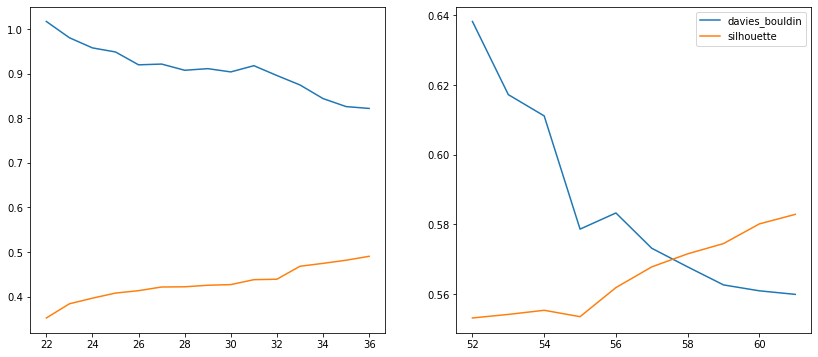

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(possible_n[20:35], davies_bouldin[20:35], label='davies_bouldin')
ax[0].plot(possible_n[20:35], silhouette[20:35], label='silhouette')
ax[1].plot(possible_n[50:60], davies_bouldin[50:60], label='davies_bouldin')
ax[1].plot(possible_n[50:60], silhouette[50:60], label='silhouette')
plt.legend()
plt.show()

In [24]:
cls = AgglomerativeClustering(n_clusters=30, 
                              affinity='manhattan',  
                              linkage='average')
labels30 = cls.fit_predict(X)

cls = AgglomerativeClustering(n_clusters=55, 
                              affinity='manhattan',  
                              linkage='average')
labels55 = cls.fit_predict(X)

### Кластеризация на основе рядов динамики

In [25]:
sales = pd.read_parquet('sales.parquet')
sales.head()

,date,shop_id,owner,number_of_counters,goods_type,total_items_sold
0,2146-01-01,0,Рейдеры,4,Съедобный хлам,6.0
1,2146-01-01,0,Рейдеры,4,Хлам,26.0
2,2146-01-01,0,Рейдеры,4,Бензак,10537.0
3,2146-01-01,1,Рейдеры,5,Съедобный хлам,17.0
4,2146-01-01,1,Рейдеры,5,Хлам,9.0


In [26]:
goods_types = sales['goods_type'].unique()
clustering_tables = {}

for goods_type in goods_types:
    clustering_tables[goods_type] = pd.read_csv('clustering/' + goods_type + '.csv', index_col=0)

Рассмотрим пример построенной таблицы

In [27]:
data = clustering_tables['Бензак']

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2146-01-01 to 2147-12-31
Columns: 845 entries, 0 to 844
dtypes: float64(845)
memory usage: 4.7+ MB


Возьмём несколько магазинов и посмотрим на имеющиеся временные ряды

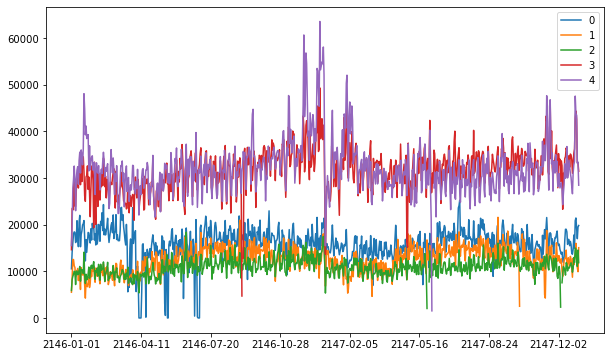

In [29]:
data[[str(i) for i in range(5)]].plot()
plt.show()

На графике мы видим сильную схожесть между продажами в третьем и четвёртом магазинах. Аналогично сильно похожи нулевой, первый и второй магазины. Альтернативный способ заключается в проведении иерархического кластерного анализа с метрикой `MAE`. В дальнейшем планируется использовать усреднённые значения, поэтому выбираем критерий `linkage`: `average`. Построим полное дерево, чтобы выбрать в дальнейшем оптимальное число кластеров. В данных присутствуют пропуски, заполним их нулями. 

In [30]:
cls = AgglomerativeClustering(n_clusters=None, 
                              affinity='manhattan', 
                              linkage='average', 
                              distance_threshold=0)

X = data.fillna(0).transpose()
cls.fit(X)

AgglomerativeClustering(affinity='manhattan', distance_threshold=0,
                        linkage='average', n_clusters=None)

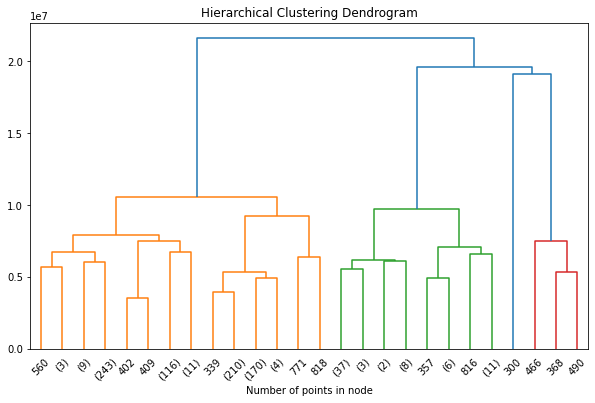

In [31]:
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(cls, truncate_mode='level', p=4)
plt.xlabel('Number of points in node')
plt.show()

Используем силуэт и индекс Дэвиса-Боулдина для оценки кластеризации и выбора наилучшего числа кластеров

In [32]:
davies_bouldin = []
silhouette = []

possible_n = np.arange(2, 20)

for n in possible_n:
    cls = AgglomerativeClustering(n_clusters=n, 
                                  affinity='manhattan', 
                                  linkage='average')
    labels = cls.fit_predict(X)
    
    davies_bouldin.append(davies_bouldin_score(X, labels))
    silhouette.append(silhouette_score(X, labels))
    
davies_bouldin = np.array(davies_bouldin)
silhouette = np.array(silhouette)

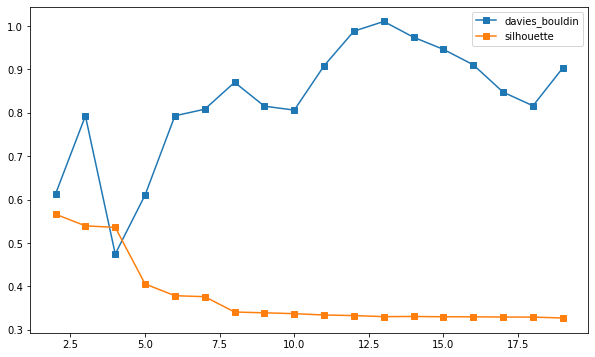

In [33]:
plt.plot(possible_n, davies_bouldin, label='davies_bouldin', marker='s')
plt.plot(possible_n, silhouette, label='silhouette', marker='s')
plt.legend()
plt.show()

По критерию Дэвиса-Боулдина наилучшее разбиение достигается при четырёх кластерах. Если же использовать силуэт, то наибольшее значение достигается при $n = 2$, при $n = 3$ и $n = 4$ значение держится примерно на том же уровне, а вот уже при $n = 5$ значение метри резко ухудшается. Вывод: оптимальное количество кластеров – четыре. 

In [34]:
cls = AgglomerativeClustering(n_clusters=4, affinity='manhattan', linkage='average')
labels4 = cls.fit_predict(X)

In [35]:
clustering = {'shop_id' : X.index.to_numpy(), 
              'Кластеризация по факторам (30)' : labels30, 
              'Кластеризация по факторам (55)' : labels55, 
              'Кластеризация по факторам (350)' : labels350, 
              'Кластеризация по рядам динамики (Бензак)' : labels4}
clustering = pd.DataFrame(clustering)
clustering.head()

,shop_id,Кластеризация по факторам (30),Кластеризация по факторам (55),Кластеризация по факторам (350),Кластеризация по рядам динамики (Бензак)
0,0,0,11,120,0
1,1,0,11,120,0
2,2,23,2,349,0
3,3,0,10,348,0
4,4,10,0,172,0


Следующий шаг заключается в построении аналогичного разбиения на кластеры по рядам динамики для каждого товара. В качестве критерия выберем точку минимума индекса Дэвиса-Боулдина. 

In [36]:
def find_best(X):
    davies_bouldin = []
    possible_n = np.arange(3, 50)
    for n in tqdm(possible_n):
        cls = AgglomerativeClustering(n_clusters=n, 
                                      affinity='manhattan', 
                                      linkage='average')
        labels = cls.fit_predict(X)
        davies_bouldin.append(davies_bouldin_score(X, labels))
    davies_bouldin = np.array(davies_bouldin)
    best = possible_n[davies_bouldin.argmin()] #выбор лучшего разбиения
    cls = AgglomerativeClustering(n_clusters=best, affinity='manhattan', linkage='average')
    labels = cls.fit_predict(X)
    return labels

In [37]:
pretitle = 'Кластеризация по рядам динамики ({})'
clustering_results = {}

for goods_type in goods_types:
    X = clustering_tables[goods_type].fillna(0).transpose()
    result = pd.DataFrame({
        'shop_id' : clustering_tables[goods_type].columns.to_numpy(),
        pretitle.format(goods_type) : find_best(X)
    })
    clustering_results[goods_type] = result

100%|██████████████████████████████████████████████████████████████████████████████████| 47/47 [00:12<00:00,  3.81it/s]


Сохраняем результаты в файл

In [38]:
clustering = clustering.drop(columns=['Кластеризация по рядам динамики (Бензак)'])
for goods_type in tqdm(goods_types):
    clustering = clustering.merge(clustering_results[goods_type], on='shop_id', how='outer')

100%|█████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 239.58it/s]


In [39]:
clustering.head()

,shop_id,Кластеризация по факторам (30),Кластеризация по факторам (55),Кластеризация по факторам (350),Кластеризация по рядам динамики (Съедобный хлам),Кластеризация по рядам динамики (Хлам),Кластеризация по рядам динамики (Бензак),Кластеризация по рядам динамики (Броня и одежда),Кластеризация по рядам динамики (Солярка),Кластеризация по рядам динамики (Ядер-Кола),Кластеризация по рядам динамики (Патроны),Кластеризация по рядам динамики (Модификации тачки),Кластеризация по рядам динамики (Оружие),Кластеризация по рядам динамики (Жидкости для тачки),Кластеризация по рядам динамики (Медпрепараты и еда)
0,0,0,11,120,2.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN
1,1,0,11,120,2.0,0.0,0,0.0,2.0,NaN,NaN,NaN,NaN,2.0,NaN
2,2,23,2,349,2.0,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0
3,3,0,10,348,2.0,0.0,0,0.0,2.0,0.0,NaN,0.0,0.0,2.0,NaN
4,4,10,0,172,2.0,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0


In [40]:
# clustering.to_csv('clustering.tsv')

В качестве основного результата выберем разбиение на 55 кластеров

In [41]:
submission = clustering[['shop_id', 'Кластеризация по факторам (55)']]
submission = submission.rename(columns={'Кластеризация по факторам (55)' : 'cluster_id'})
submission.head()

,shop_id,cluster_id
0,0,11
1,1,11
2,2,2
3,3,10
4,4,0


In [42]:
# submission.to_csv('submission.tsv', index=False)